In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import tifffile
from PIL import Image
import pytest
import skimage as ski
from skimage.transform import rescale, resize
from skimage.restoration import denoise_wavelet, estimate_sigma, calibrate_denoiser,  denoise_tv_chambolle, denoise_tv_bregman, denoise_bilateral
from skimage import color, data
import skimage.data
from skimage import img_as_float
import pylops
from itertools import product
import os

In [88]:
# path = '../../../../../../data/earth_explorer_images/'
path = '/data/earth_explorer_images/'
filename = 'C3311604.SES.100201791.tif'
image_file = path + filename 

In [89]:
image = tifffile.imread(image_file)
print(image.shape)

(3, 7561, 6491)


In [90]:
pixel_values = image.flatten()

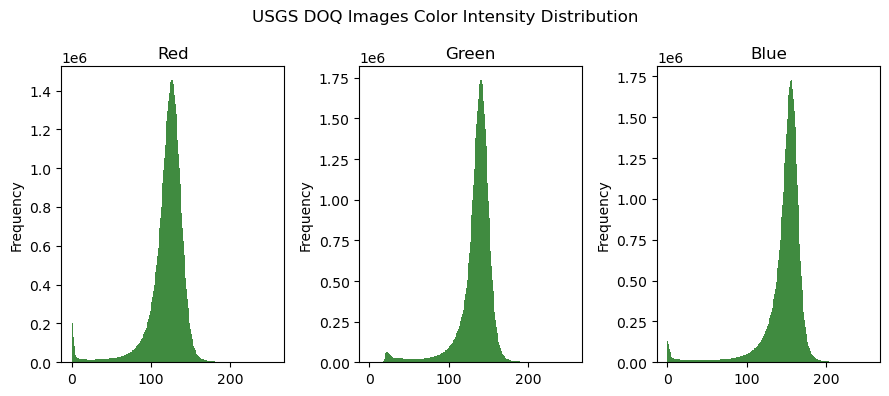

In [91]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
fig.set_size_inches(9, 4)
pixel_values = image[0].flatten()
axs[0].hist(pixel_values, bins = 256, range=(0, 255), alpha = 0.75, color='darkgreen');

pixel_values = image[1].flatten()
axs[1].hist(pixel_values, bins = 256, range=(0, 255), alpha = 0.75, color='darkgreen');

pixel_values = image[2].flatten()
axs[2].hist(pixel_values, bins = 256, range=(0, 255), alpha = 0.75, color='darkgreen');

plt.suptitle('USGS DOQ Images Color Intensity Distribution')
#axs.xaxis.set_label_position('bottom')
axs[0].set_title('Red')
axs[1].set_title('Green')
axs[2].set_title('Blue')

axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')
axs[2].set_ylabel('Frequency')

plt.savefig('doq_pixel_distribution.png', dpi=300)

In [92]:
print(np.min(image))
print("Max: ", np.max(image))
print(type(image))
print("Mean: ", np.mean(image))
print("Median: ", np.median(image))
print("25th percentile: ", np.percentile(image, 25))
print("75th percentile: ", np.percentile(image, 75))

0
Max:  255
<class 'numpy.ndarray'>
Mean:  133.19606325798668
Median:  137.0
25th percentile:  123.0
75th percentile:  150.0


In [93]:
is_nan = np.isnan(image)
has_nan = np.any(is_nan)
print(has_nan)

False


147235353
(3, 7561, 6491)
7561 6491
(7561, 6491)


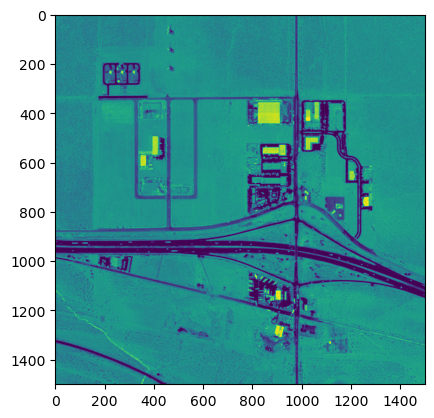

In [94]:
print(image.size)
print(image.shape)
w, h = image.shape[1], image.shape[2]
print(w, h)
red = image[0]
print(red.shape)
plt.imshow(image[0, 3000:4500, 1000:2500])

#### Converting the images to grayscale

In [95]:
# Converting RGB image to greyscale with skimage library 'color'
full_gray_img = color.rgb2gray(image, channel_axis=0)

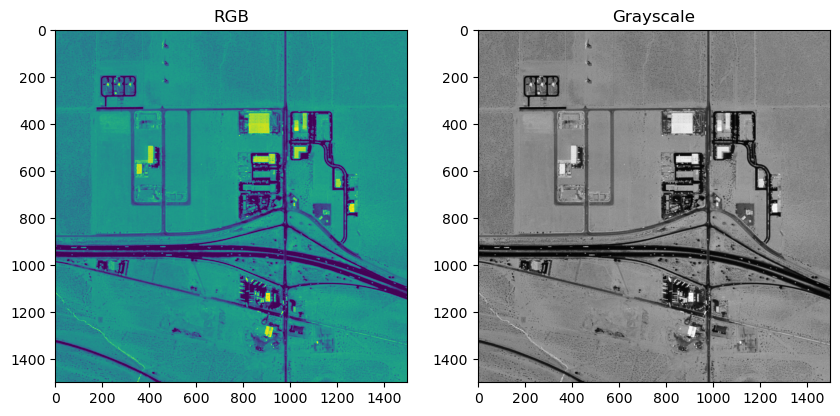

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image[0, 3000:4500, 1000:2500])
axs[1].imshow(full_gray_img[3000:4500, 1000:2500], cmap='gray')
axs[0].set_title("RGB")
axs[1].set_title("Grayscale")

plt.savefig('DOQ_RGB_grayscale.png', dpi=100)

#### Resizing images to same resolution as Landsat-1 (Landsat-1 is 20x22m resolution while DOQ is 1x1 m)

In [97]:
# gray_image_resized = skimage.transform.resize(full_gray_img, (w // 20, h // 20), anti_aliasing=True)
# print(7561/20, 6491/20)
# print(gray_image_resized.shape)  # 224x224 # 512x512 used for training

In [98]:
# #plt.imshow(gray_image_resized)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(full_gray_img, cmap='gray')
# axs[1].imshow(gray_image_resized, cmap='gray')
# axs[0].set_title("Gray original")
# axs[1].set_title("Resized")

# # plt.savefig('DOQ_RGB_gray_resized_full.png', dpi=300)

In [99]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 12))
# axs[0].imshow(full_gray_img[3000:4500, 1000:2500], cmap='gray') #
# axs[1].imshow(gray_image_resized[150:225, 50:125], cmap='gray') # 
# axs[0].set_title("Gray original")
# axs[1].set_title("Resized")

In [100]:
# # 224x224 gray image shape: (378, 324)

# fig, axs = plt.subplots(1, 2, figsize=(12, 12))
# axs[0].imshow(full_gray_img[1000:5480, 0:4480], cmap='gray')
# axs[1].imshow(gray_image_resized[50:274, 0:224], cmap='gray')
# axs[0].set_title("Gray original")
# axs[1].set_title("Resized")

# # plt.savefig('DOQ_RGB_gray_resized_detail.png', dpi=300)

In [101]:
#plt.imshow(full_gray_img[0:224,6000:6224], cmap='gray')

In [102]:
# plt.imsave('data/grayscale_DOQ.png', gray_image_resized)

### Added noise

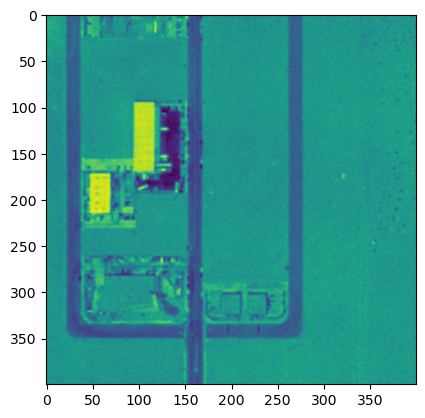

In [103]:
# # Testing added noise on Resized gray images:
# gray_img_copy = gray_image_resized.copy()
# gray_img = gray_image_resized[50:274, 0:224]
# gray_img_copy = gray_img.copy()

# gray_img = full_gray_img[3000:3500, 1000:2500].copy()
gray_img = full_gray_img[3400:3800, 1300:1700].copy()
plt.imshow(gray_img)

### Standard_normal

In [104]:
# add random noise to noise-free image:
noisy_img = ski.img_as_float(gray_img.astype(np.float32))   # Noise-Free image as float
print(np.max(noisy_img), np.min(noisy_img))

rng = np.random.default_rng()                               # random  
noisy_img += 0.1 * rng.standard_normal(noisy_img.shape)     # adding noise standard_normal
print(np.max(noisy_img), np.min(noisy_img))
noisy_img = np.clip(noisy_img, 0, 1)                        # clipping values outside 0-1
print(np.max(noisy_img), np.min(noisy_img))

0.9786659 0.0996498
1.2968924 -0.19905321
1.0 0.0


In [105]:
## Estimating Noise:
sigma_estimation = estimate_sigma(noisy_img, channel_axis=None)
print(sigma_estimation)
denoised_img = denoise_wavelet(noisy_img, sigma=sigma_estimation, rescale_sigma=True)

# denoising_function = calibrate_denoiser(img, denoise_wavelet, denoise_parameters=parameters)
parameter_ranges = {'sigma': np.arange(0.1, 0.2, 0.01)}
calibrated_denoiser = calibrate_denoiser(noisy_img, denoise_wavelet, denoise_parameters=parameter_ranges)
# Denoised image using calibrated denoiser
calibrated_denoised_img = calibrated_denoiser(noisy_img)

0.10063330142934147


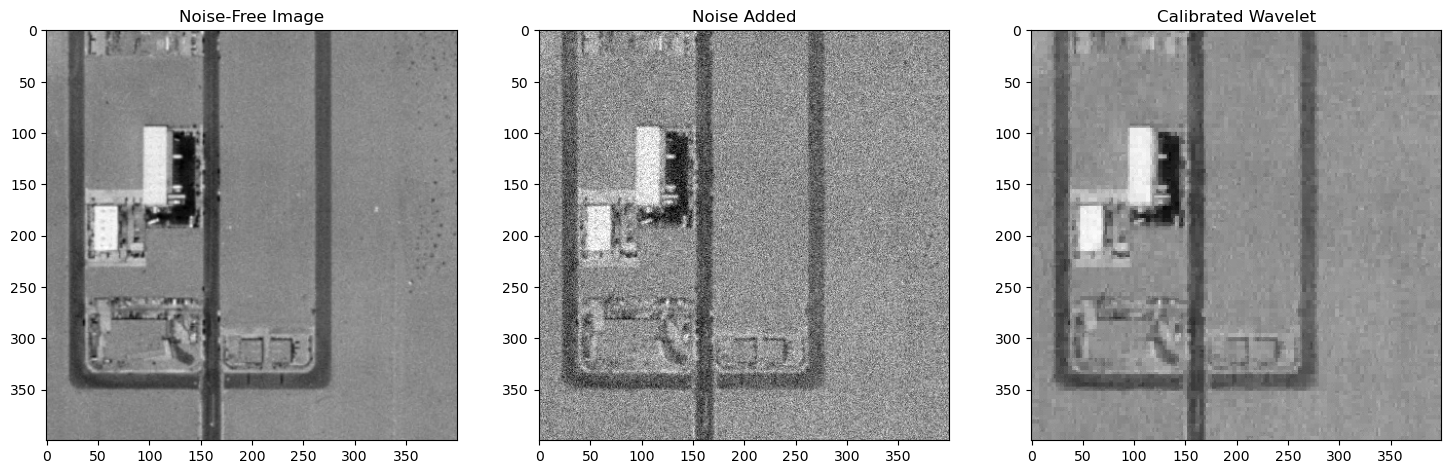

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10), squeeze=True)
axs[0].imshow(gray_img, cmap="gray")         # Original tile
axs[1].imshow(noisy_img, cmap="gray")          # Noise added image
axs[2].imshow(calibrated_denoised_img, cmap="gray")

axs[0].set_title("Noise-Free Image")
axs[1].set_title("Noise Added")
axs[2].set_title("Calibrated Wavelet")
plt.savefig('doq_wavelet-denoise2.png', dpi=400)

### Random Normal noise:

In [107]:
print(np.max(gray_img), np.min(gray_img))
noisy_img2 = ski.img_as_float(gray_img.astype(np.float32))     # Noise-Free image as float
print(np.max(noisy_img2), np.min(noisy_img2))
noisy_img2 += np.random.normal(0, 0.1, noisy_img2.shape)       # random.normal
print(np.max(noisy_img2), np.min(noisy_img2))
noisy_img2 = np.clip(noisy_img2, 0, 1) 
print(np.max(noisy_img2), np.min(noisy_img2))

0.9786658823529412 0.09964980392156861
0.9786659 0.0996498
1.2679461 -0.15750979
1.0 0.0


In [108]:
## Estimating Noise:
sigma_estimation2 = estimate_sigma(noisy_img2, channel_axis=None)
print(sigma_estimation2)
denoised_img = denoise_wavelet(noisy_img2, sigma=sigma_estimation2, rescale_sigma=True)

# denoising_function = calibrate_denoiser(img, denoise_wavelet, denoise_parameters=parameters)
parameter_ranges = {'sigma': np.arange(0.1, 0.2, 0.01)}
calibrated_denoiser = calibrate_denoiser(noisy_img2, denoise_wavelet, denoise_parameters=parameter_ranges)
# Denoised image using calibrated denoiser
calibrated_denoised_img = calibrated_denoiser(noisy_img2)

0.10024730136291612


Text(0.5, 1.0, 'Calibrated Wavelet')

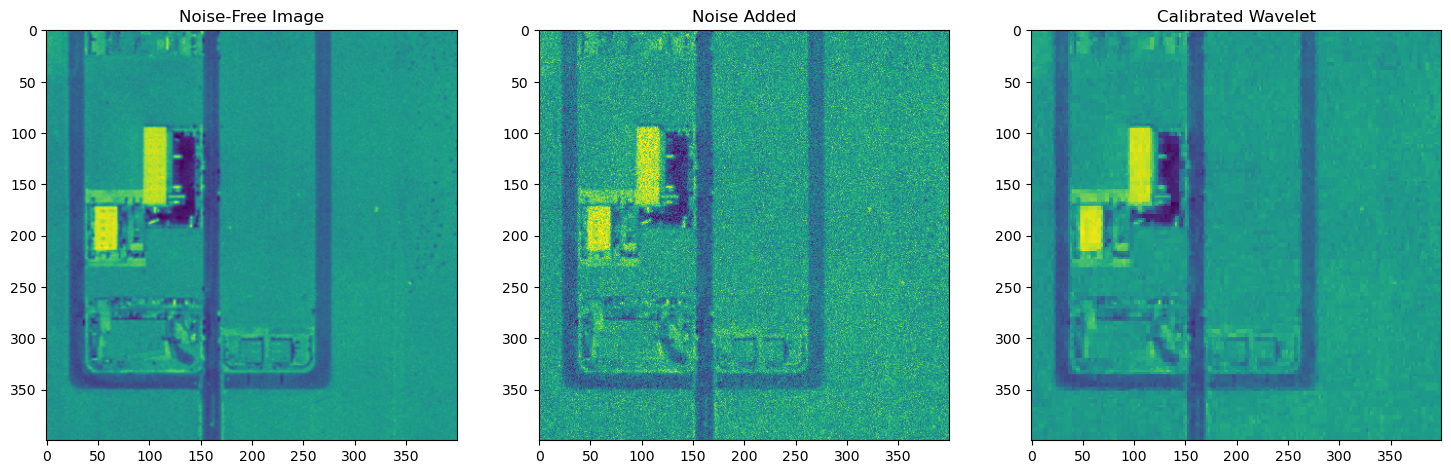

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10), squeeze=True)
axs[0].imshow(gray_img)         # Original tile
axs[1].imshow(noisy_img2)          # Noise added image
axs[2].imshow(calibrated_denoised_img)

axs[0].set_title("Noise-Free Image")
axs[1].set_title("Noise Added")
axs[2].set_title("Calibrated Wavelet")
# plt.savefig('doq_wavelet-denoise2.png', dpi=300)

### Standard Normal Noise on full sized gray image:

In [110]:
# Testing added noise on Resized gray images:
#gray_img_full_copy = full_gray_img.copy()
img = gray_img #gray_img_full_copy[1000:5480, 0:4480].copy()

In [111]:
# add random noise to noise-free image:
noisy_img = ski.img_as_float(gray_img.astype(np.float32))   # Noise-Free image as float
print(np.max(noisy_img), np.min(noisy_img))

rng = np.random.default_rng()                               # random  
noisy_img += 0.1 * rng.standard_normal(noisy_img.shape)     # adding noise standard_normal
print(np.max(noisy_img), np.min(noisy_img))
noisy_img = np.clip(noisy_img, 0, 1)                        # clipping values outside 0-1
print(np.max(noisy_img), np.min(noisy_img))

0.9786659 0.0996498
1.2304407 -0.15859029
1.0 0.0


In [112]:
## Estimating Noise:
sigma_estimation = estimate_sigma(noisy_img, channel_axis=None)
print(sigma_estimation)
denoised_img = denoise_wavelet(noisy_img, sigma=sigma_estimation, rescale_sigma=True)

parameter_ranges = {'sigma': np.arange(0.1, 0.2, 0.01)}
calibrated_denoiser = calibrate_denoiser(noisy_img, denoise_wavelet, denoise_parameters=parameter_ranges)
# Denoised image using calibrated denoiser
calibrated_denoised_img = calibrated_denoiser(noisy_img)

0.09858847535630093


In [113]:
# plt.imshow(img[2000:3500, 1000:2500])         # Original tile

Text(0.5, 1.0, 'Calibrated Wavelet')

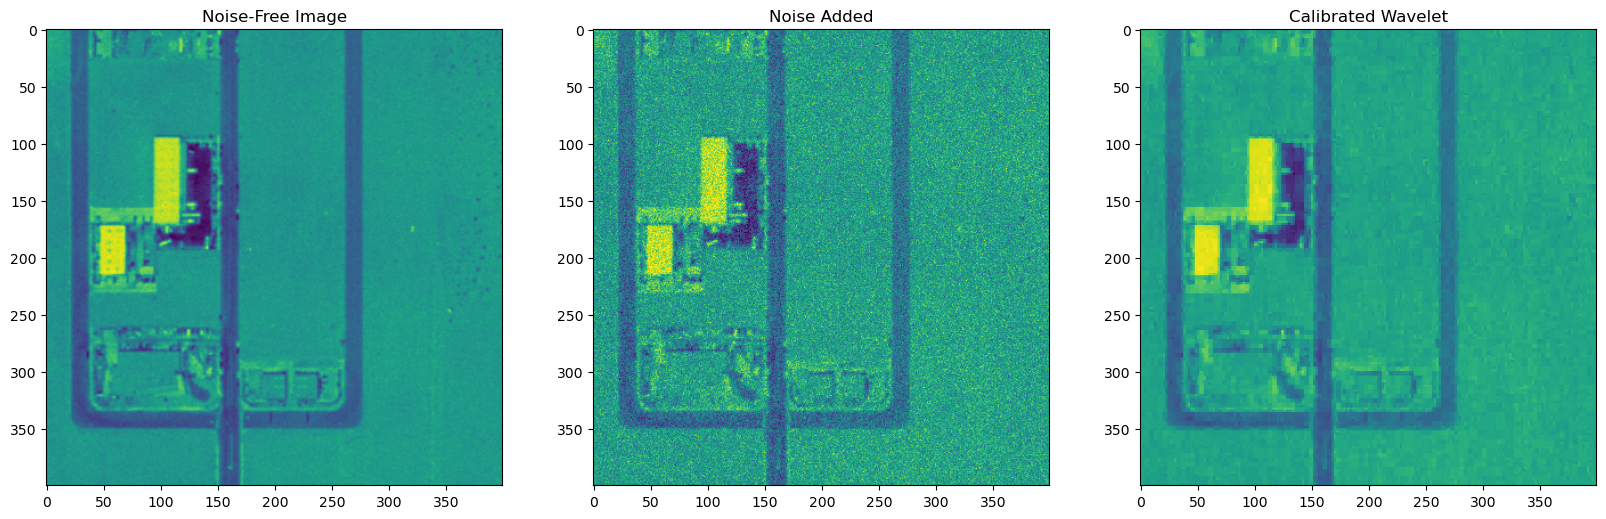

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(20, 15), squeeze=True)
axs[0].imshow(img)         # Original tile
axs[1].imshow(noisy_img)          # Noise added image
axs[2].imshow(calibrated_denoised_img)

axs[0].set_title("Noise-Free Image")
axs[1].set_title("Noise Added")
axs[2].set_title("Calibrated Wavelet")
# plt.savefig('doq_wavelet-denoise2.png', dpi=300)

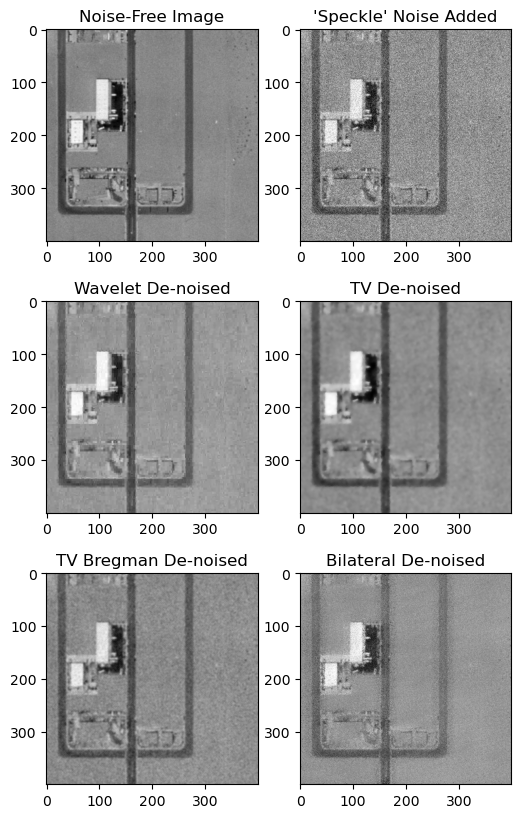

In [128]:
gray_img_float = ski.img_as_float(gray_img)   # Noisy image as float
# noisy_img # has added noise 
wavelet_denoised_img = denoise_wavelet(noisy_img, sigma=sigma_estimation, rescale_sigma=True)
tv_denoised_img = denoise_tv_chambolle(noisy_img, weight=0.2) #  eps=5
tv_bregman_denoised_img = denoise_tv_bregman(noisy_img, weight=0.2, eps=0.5)
bilateral_denoise_img =  denoise_bilateral(noisy_img, sigma_spatial = 5)

fig, axs = plt.subplots(3, 2, figsize=(6, 10))
axs[0, 0].imshow(gray_img, cmap="gray")
axs[0, 1].imshow(noisy_img, cmap="gray")
axs[1, 0].imshow(wavelet_denoised_img, cmap="gray")
axs[1, 1].imshow(tv_denoised_img, cmap="gray")
axs[2, 0].imshow(tv_bregman_denoised_img, cmap="gray")
axs[2, 1].imshow(bilateral_denoise_img, cmap="gray")

axs[0, 0].set_title("Noise-Free Image")
axs[0, 1].set_title("'Speckle' Noise Added")
axs[1, 0].set_title("Wavelet De-noised")
axs[1, 1].set_title("TV De-noised")
axs[2, 0].set_title("TV Bregman De-noised")
axs[2, 1].set_title("Bilateral De-noised")
#plt.show()
plt.savefig('data/images/doq_denoise_methods3x2.png', dpi=300)

#### Cropping full sized DOQ images to tiles:

In [ ]:
#tile(filename, path, 'data/doq_data_resized/', 512) 

In [ ]:
path = '/data/earth_explorer_images/'
filename = 'C3311604.SES.100201791.tif' ## full_gray_img
image_file = path + filename 

In [ ]:
# this doesn't work. Can read rgb tiles as rgb, convert it to grayscale and do processing   

In [ ]:
import scipy.misc
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    #img = color.rgb2gray(tiffimage, channel_axis=0)

    w, h = img.shape
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)
